In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.metrics import MeanIoU
import matplotlib.pyplot as plt

In [7]:
!nvidia-smi

Mon Mar 10 21:49:36 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 571.96                 Driver Version: 571.96         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1650 ...  WDDM  |   00000000:02:00.0 Off |                  N/A |
| N/A   63C    P8              7W /   35W |    2813MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
train_dir = 'dataset/U_NET/train/'
val_dir = 'dataset/U_NET/validation/'
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 3

def load_data(data_dir):
    X, y = [], []
    for subfolder in os.listdir(data_dir):
        subfolder_path = os.path.join(data_dir, subfolder)
        if not os.path.isdir(subfolder_path):
            continue

        image_path = os.path.join(subfolder_path, 'images', os.listdir(os.path.join(subfolder_path, 'images'))[0])
        image = load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
        image = img_to_array(image) / 255.0
        X.append(image)

        # Combine all masks into one binary mask and resize
        mask_files = os.listdir(os.path.join(subfolder_path, 'masks'))
        combined_mask = np.zeros((IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)
        for mask_file in mask_files:
            mask_path = os.path.join(subfolder_path, 'masks', mask_file)
            mask = load_img(mask_path, color_mode="grayscale", target_size=(IMG_HEIGHT, IMG_WIDTH))
            mask = img_to_array(mask).squeeze() > 0  # Convert to true false for each pixel
            combined_mask = np.logical_or(combined_mask, mask).astype(np.uint8) # use OR fun() and to type [0 or 1]
        y.append(combined_mask)

    return np.array(X), np.array(y)

X_train_full, y_train_full = load_data(train_dir)

print(f"Full training images shape: {X_train_full.shape}, Full training masks shape: {y_train_full.shape}")

Full training images shape: (670, 128, 128, 3), Full training masks shape: (670, 128, 128)


In [3]:
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=21)

print(f"Training images shape: {X_train.shape}, Training masks shape: {y_train.shape}")
print(f"Validation images shape: {X_val.shape}, Validation masks shape: {y_val.shape}")

# (H, W, 1)
y_train = np.expand_dims(y_train, axis=-1)
y_val = np.expand_dims(y_val, axis=-1)

Training images shape: (536, 128, 128, 3), Training masks shape: (536, 128, 128)
Validation images shape: (134, 128, 128, 3), Validation masks shape: (134, 128, 128)


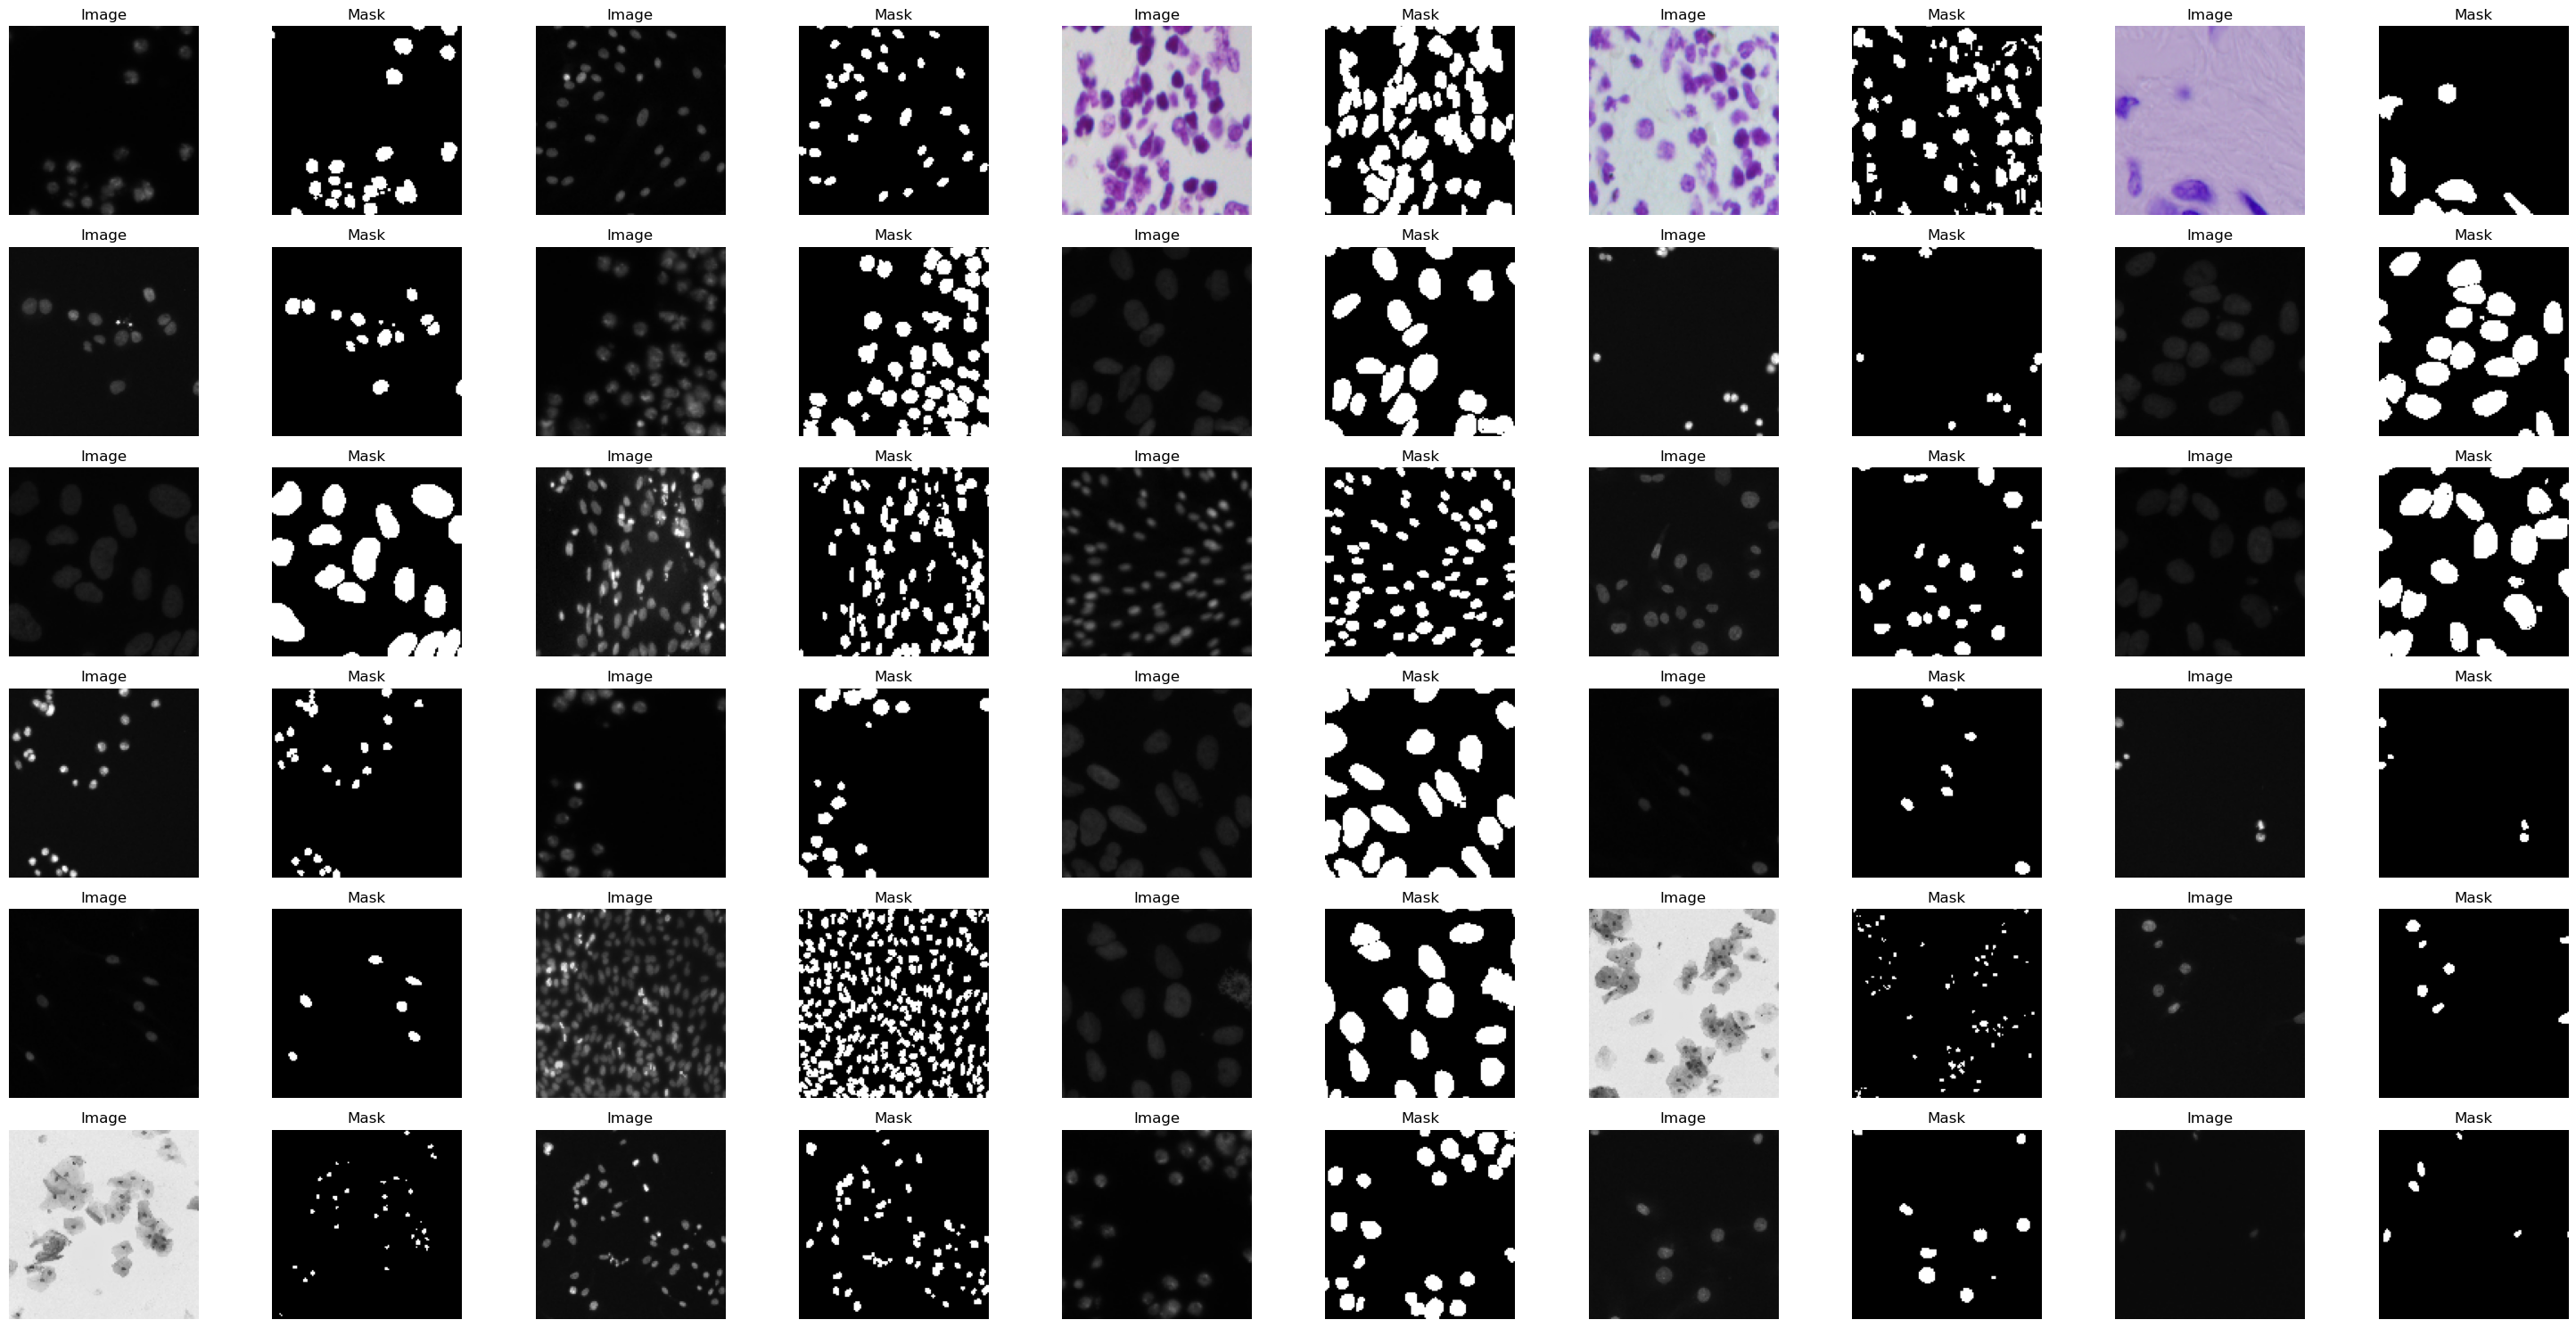

In [4]:

def display_images_and_masks(X, y, rows=3, cols=10, figsize=(20, 10)):
    num_images = min(len(X), rows * cols)  # Ensure we don't exceed the number of available images
    fig, axes = plt.subplots(rows * 2, cols, figsize=figsize)  # Double the columns for images + masks

    axes = axes.flatten()

    for i in range(num_images):
        # Plot the image
        axes[i*2].imshow(X[i])
        axes[i*2].set_title("Image")
        axes[i*2].axis('off')

        # Plot the corresponding mask
        axes[i*2+1].imshow(y[i], cmap='gray')
        axes[i*2+1].set_title("Mask")
        axes[i*2+1].axis('off')

    # Hide any unused subplots
    for j in range(num_images * 2, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# Display the first 72 images and masks (6 rows x 12 cols)
display_images_and_masks(X_train_full[:30], y_train_full[:30], rows=3, cols=10, figsize=(30, 15))

In [5]:
import tensorflow as tf

def compute_iou(y_true, y_pred, threshold=0.5):
    # Binarize predictions using the threshold
    y_pred = tf.cast(y_pred > threshold, tf.float32)

    # Compute intersection and union
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])  # Sum over spatial dimensions
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3]) - intersection

    # Avoid division by zero
    iou = intersection / (union + 1e-7)

    # Return the mean IoU across the batch
    return tf.reduce_mean(iou)
    
def unet(input_size=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)):
    inputs = Input(input_size)

    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottleneck
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)

    # Decoder
    up5 = UpSampling2D(size=(2, 2))(conv4)
    merge5 = concatenate([conv3, up5], axis=3)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(merge5)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(conv5)

    up6 = UpSampling2D(size=(2, 2))(conv5)
    merge6 = concatenate([conv2, up6], axis=3)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(conv6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    merge7 = concatenate([conv1, up7], axis=3)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(conv7)

    # Output layer
    outputs = Conv2D(1, 1, activation='sigmoid')(conv7)

    model = Model(inputs=[inputs], outputs=[outputs])

    
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=[compute_iou])
    return model

model = unet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [6]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    filepath='models/best_model2.h5',
    monitor='val_loss', 
    save_best_only=True,
    verbose=1
)


history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=16,
    epochs=5,
    verbose=1,
    callbacks=[early_stopping, checkpoint])

Epoch 1/5
34/34 [==============================] - ETA: 0s - loss: 0.5670 - compute_iou: 0.0043
Epoch 1: val_loss improved from inf to 0.42669, saving model to models\best_model2.h5
34/34 [==============================] - 38s 616ms/step - loss: 0.5670 - compute_iou: 0.0043 - val_loss: 0.4267 - val_compute_iou: 0.0000e+00
Epoch 2/5
34/34 [==============================] - ETA: 0s - loss: 0.4001 - compute_iou: 0.0000e+00
Epoch 2: val_loss improved from 0.42669 to 0.35532, saving model to models\best_model2.h5
34/34 [==============================] - 12s 364ms/step - loss: 0.4001 - compute_iou: 0.0000e+00 - val_loss: 0.3553 - val_compute_iou: 0.0000e+00
Epoch 3/5
34/34 [==============================] - ETA: 0s - loss: 0.3181 - compute_iou: 0.0000e+00
Epoch 3: val_loss improved from 0.35532 to 0.25406, saving model to models\best_model2.h5
34/34 [==============================] - 13s 377ms/step - loss: 0.3181 - compute_iou: 0.0000e+00 - val_loss: 0.2541 - val_compute_iou: 0.0000e+00
Epoc

In [8]:
def compute_iou(y_true, y_pred, threshold=0.5):
    y_pred = (y_pred > threshold).astype(np.uint8)
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    iou = intersection / (union + 1e-7)  # Add epsilon to avoid division by zero
    return iou

# Example usage during evaluation
predictions = model.predict(X_val)
ious = []
for i in range(len(predictions)):
    iou = compute_iou(y_val[i], predictions[i], threshold=0.5)
    ious.append(iou)
print(f"Average IoU: {np.mean(ious)}")

5/5 [==============================] - 8s 158ms/step
Average IoU: 0.6392547698043649


In [ ]:
# Plot training & validation loss values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation IoU values
plt.subplot(1, 2, 2)
plt.plot(history.history['mean_io_u'])
plt.plot(history.history['val_mean_io_u'])
plt.title('Model IoU')
plt.ylabel('IoU')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.show()

In [10]:
from keras.models import load_model
loaded_model = load_model("models/best_model1_0.73_IOU.h5")

In [11]:
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
val_dir = 'dataset/U_NET/validation/'
def load_test_data(data_dir):
    X_test = []
    valid_subfolders = 0

    for subfolder in os.listdir(data_dir):
        subfolder_path = os.path.join(data_dir, subfolder)
        if subfolder.startswith('.'):
            continue
        
        if not os.path.isdir(subfolder_path):
            print(f"Skipping {subfolder}: Not a directory.")
            continue

        image_folder = os.path.join(subfolder_path, 'images')
        
        if not os.path.exists(image_folder) or not os.path.isdir(image_folder):
            print(f"Skipping {subfolder}: Missing 'images' folder.")
            continue

        image_files = [f for f in os.listdir(image_folder) if not f.startswith('.')]
        valid_subfolders += 1
    
        try:
            image_path = os.path.join(image_folder, image_files[0])
            image = load_img(image_path, target_size=(128, 128))
            image = img_to_array(image) / 255.0
            X_test.append(image)
        except Exception as e:
            print(f"Error loading image from {subfolder}: {e}")

    print(f"Total valid subfolders processed: {valid_subfolders}")
    return np.array(X_test)

X_test = load_test_data(val_dir)
print(f"Test images shape: {X_test.shape}")

Total valid subfolders processed: 65
Test images shape: (65, 128, 128, 3)


3/3 [==============================] - 2s 932ms/step


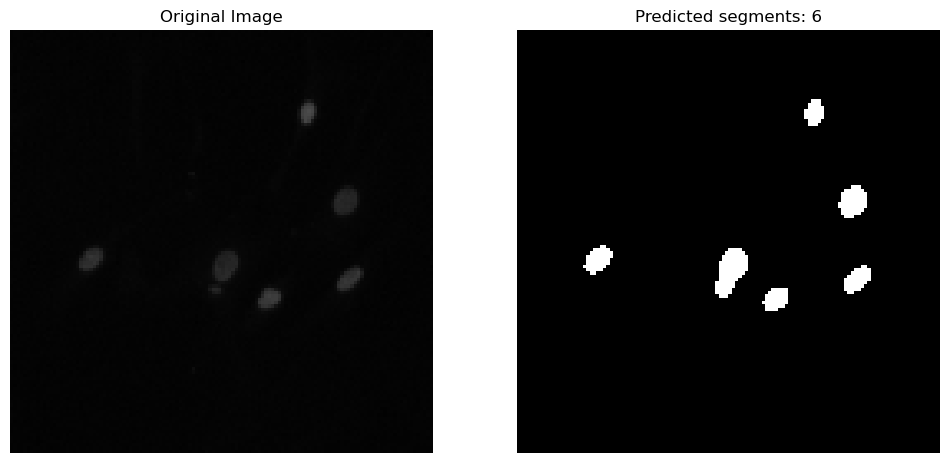

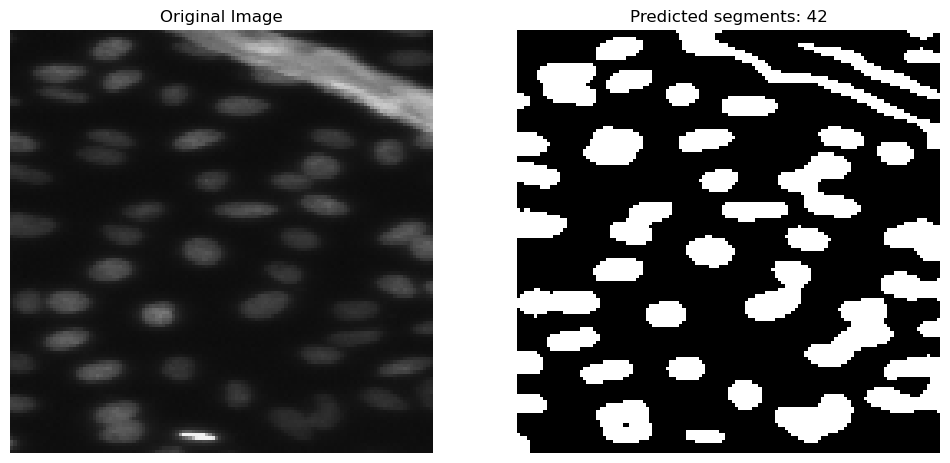

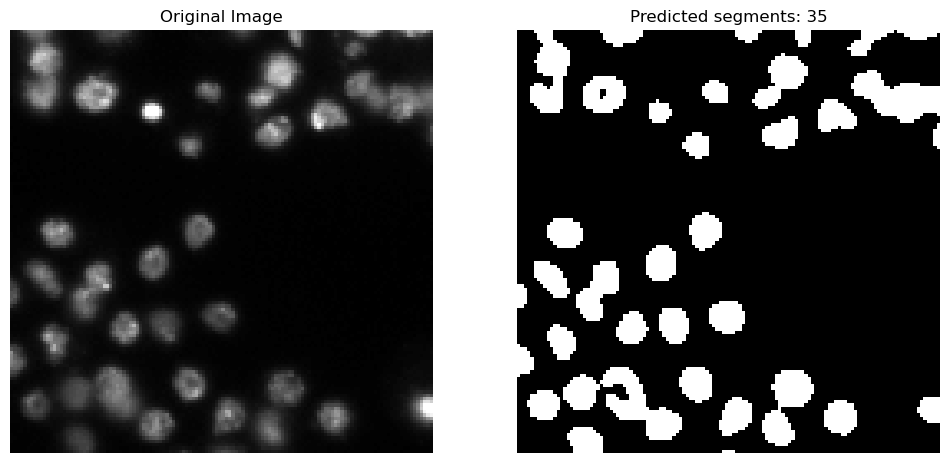

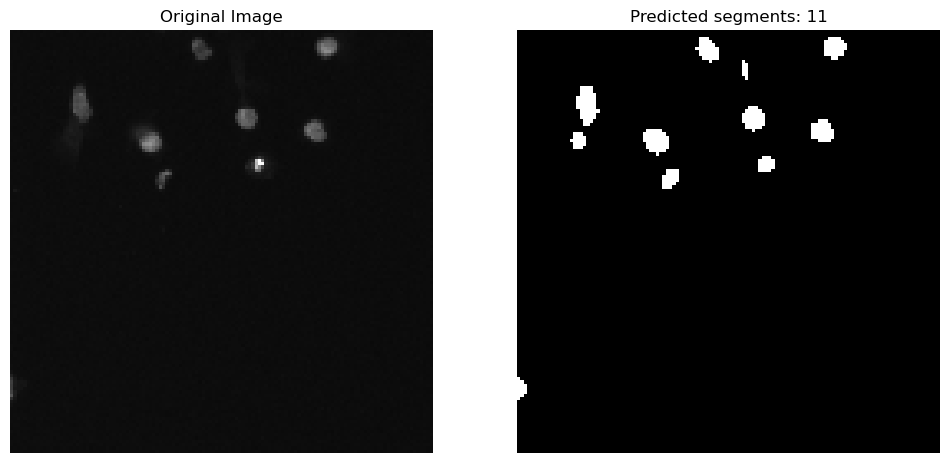

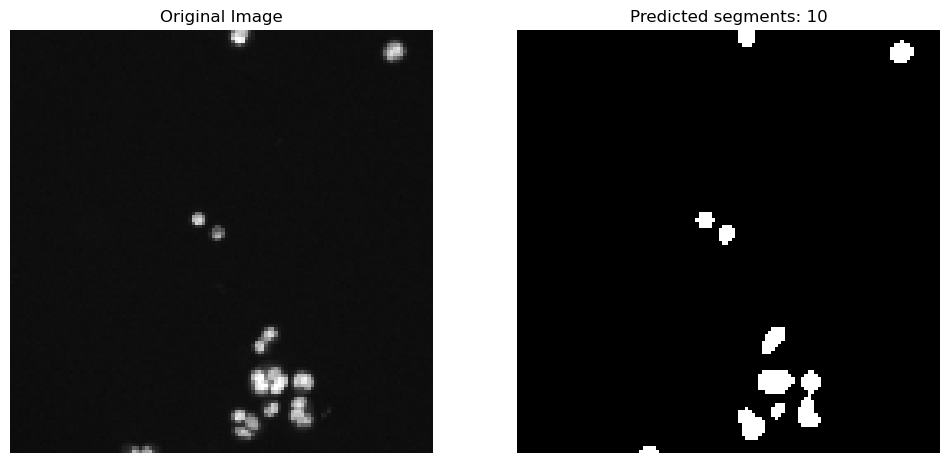

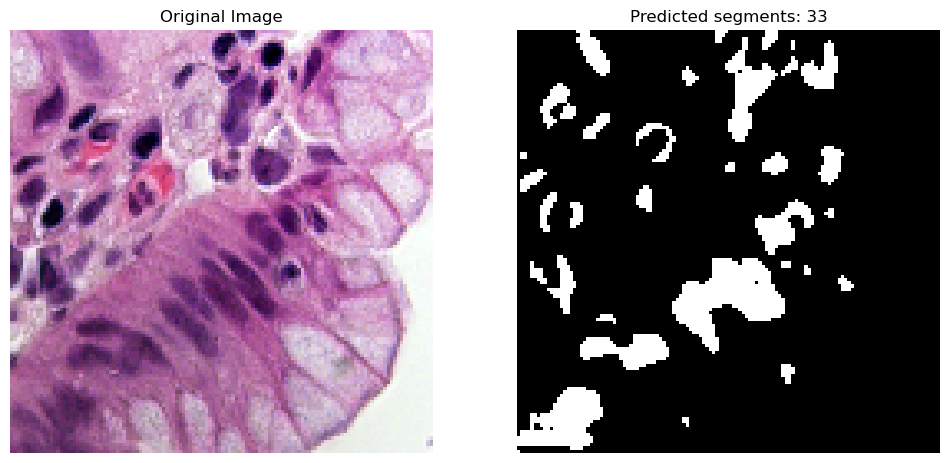

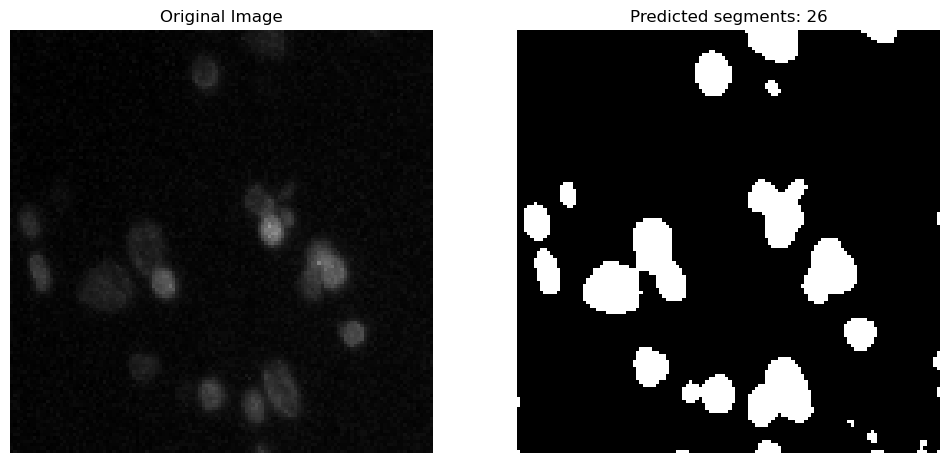

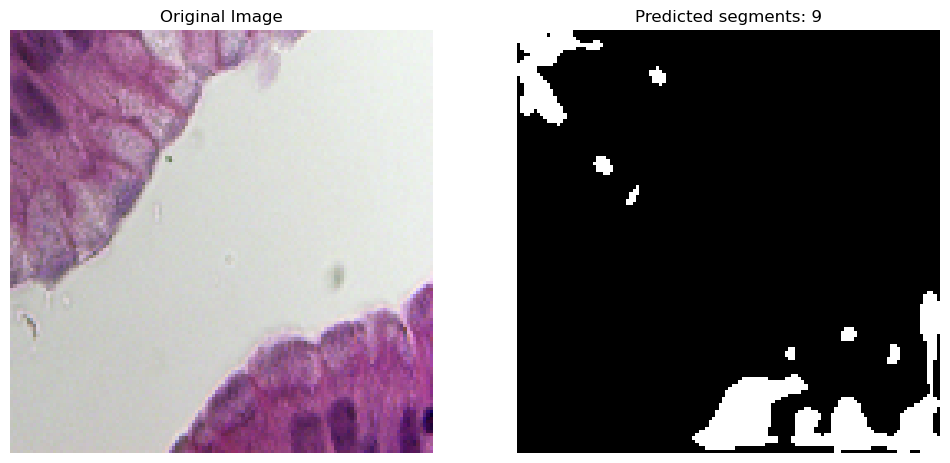

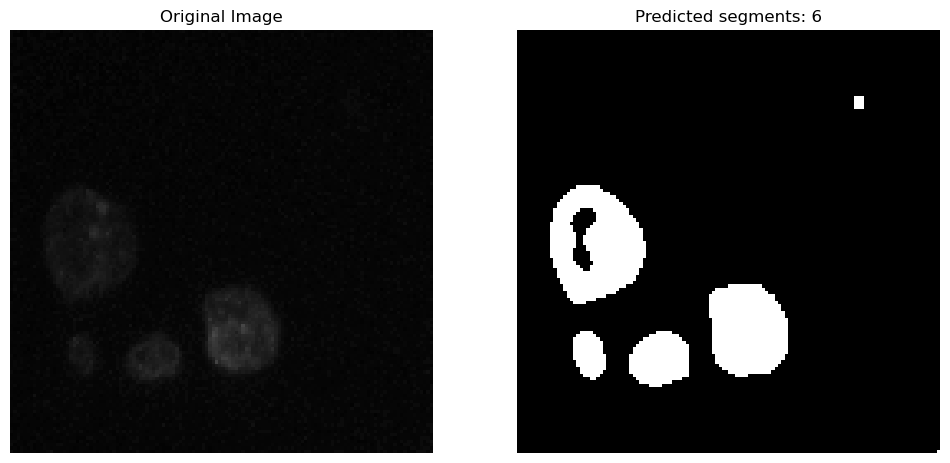

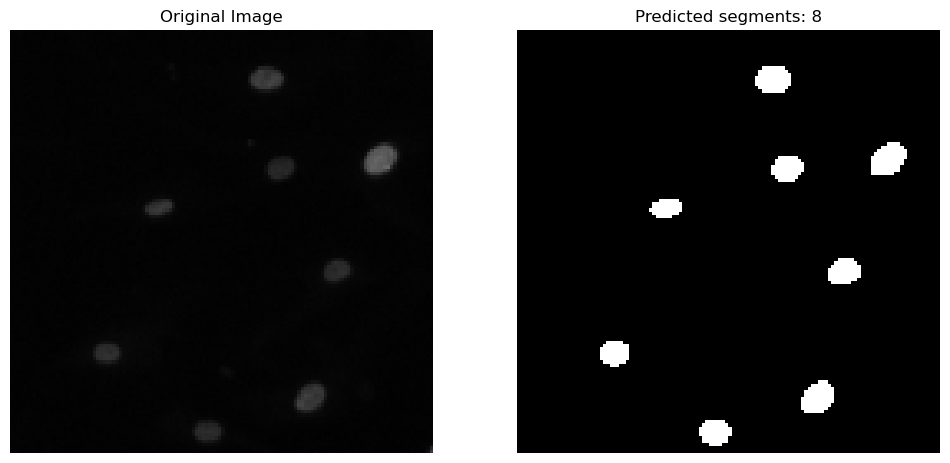

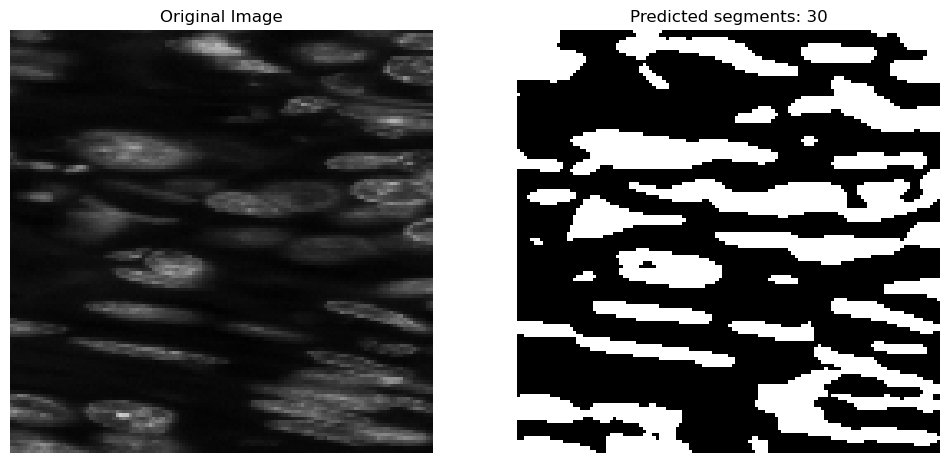

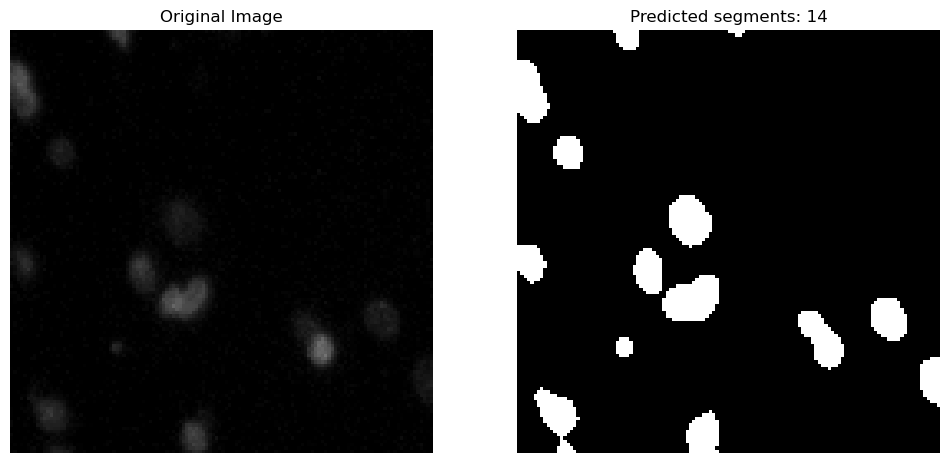

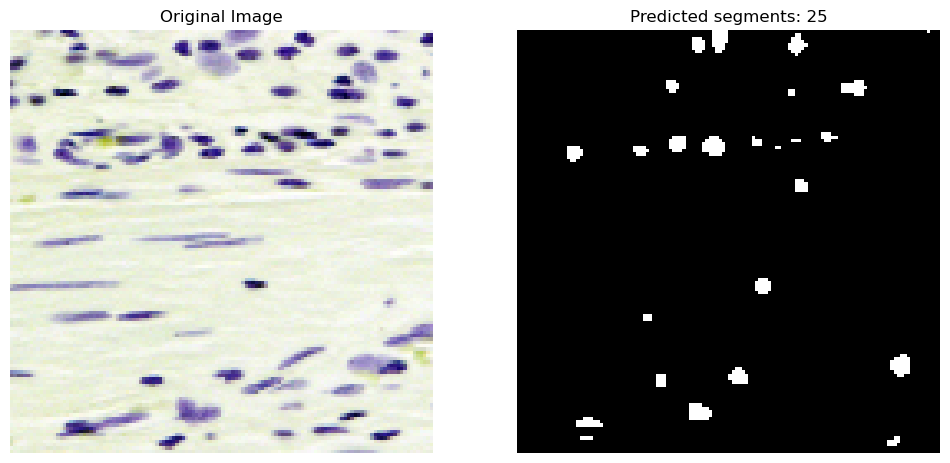

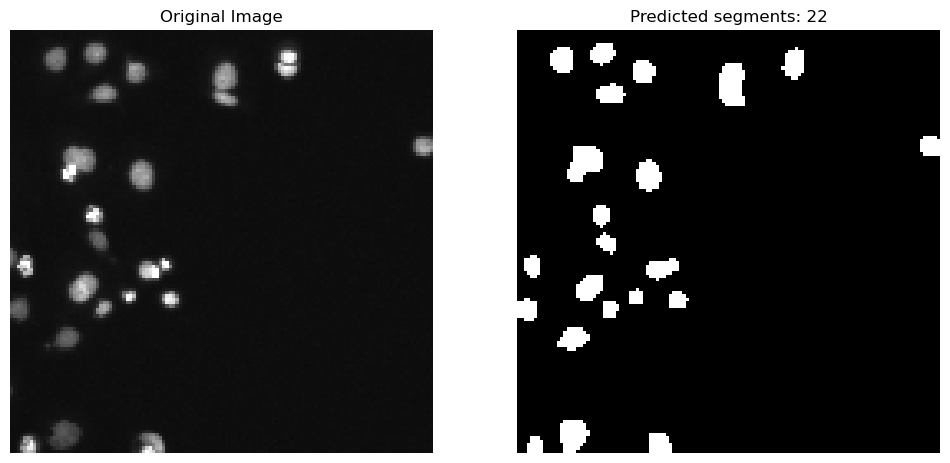

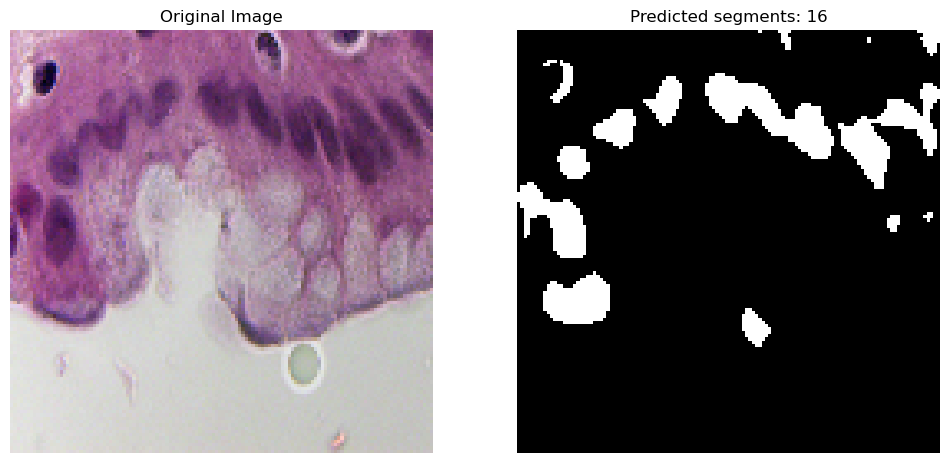

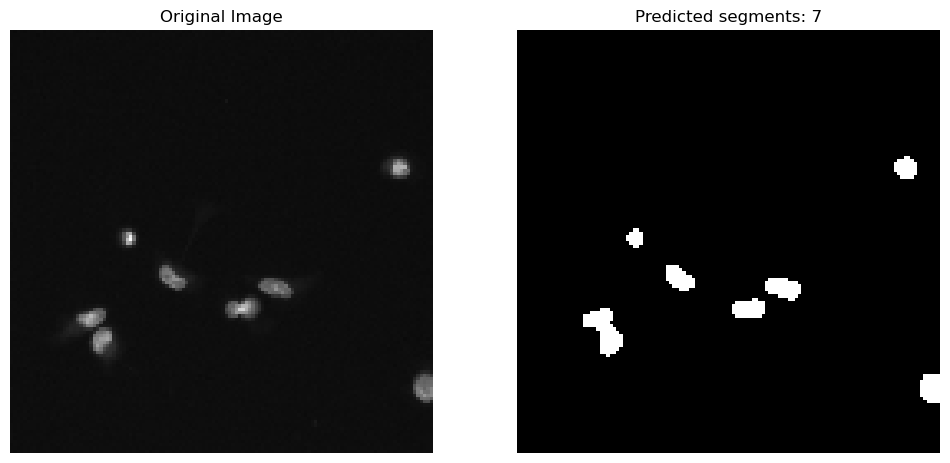

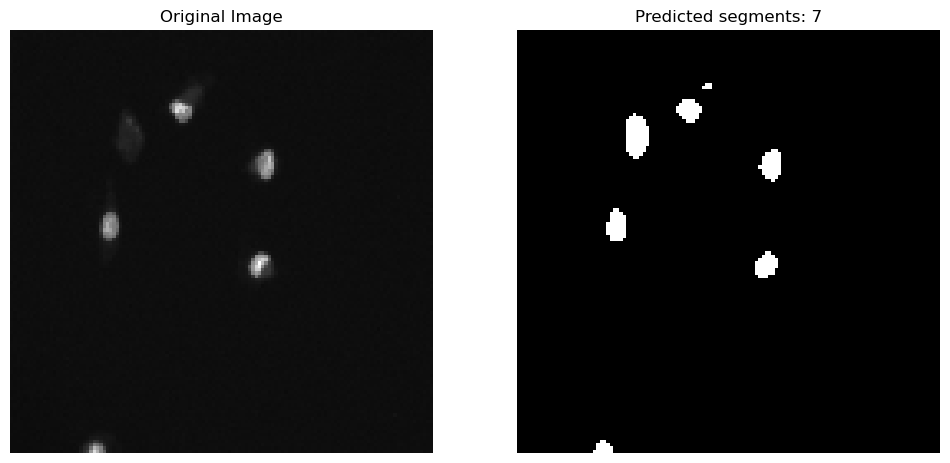

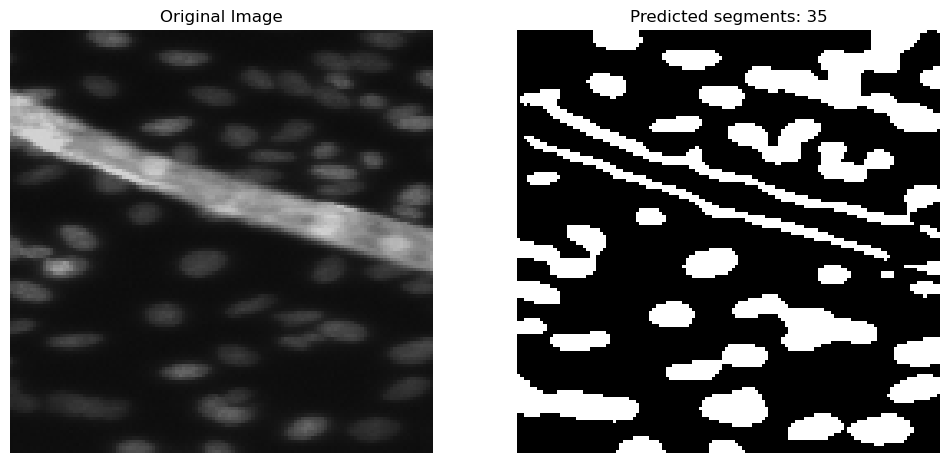

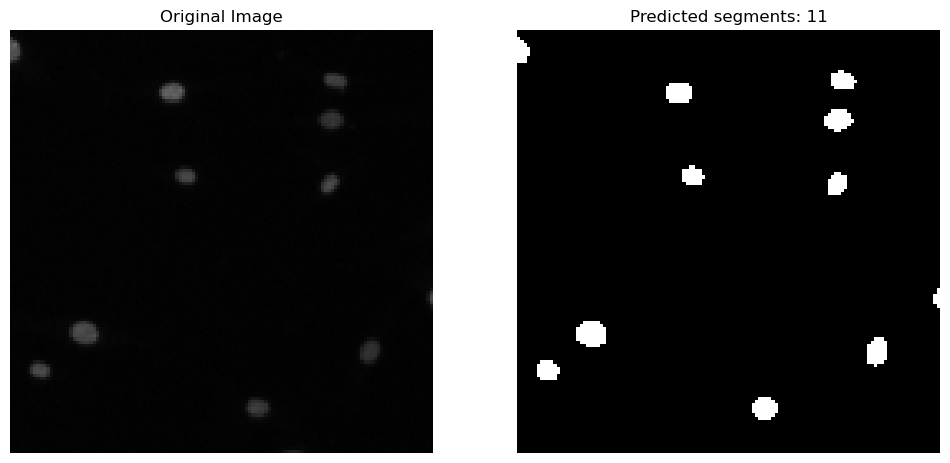

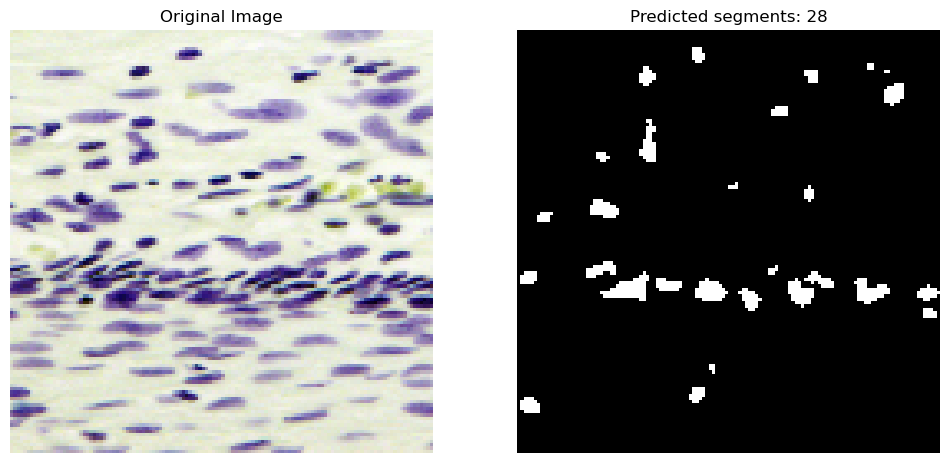

In [12]:
# predictions on test images
def predict_and_visualize(model, X_test, num_images=20):
    predictions = model.predict(X_test)
    predictions = (predictions > 0.4).astype(np.uint8)
    segments = counts(predictions)
    
    for i in range(min(num_images, len(X_test))):
        plt.figure(figsize=(12, 6))
        
        plt.subplot(1, 2, 1)
        plt.title("Original Image")
        plt.imshow(X_test[i])
        plt.axis("off")
        
        plt.subplot(1, 2, 2)
        plt.title(f"Predicted segments: {segments[i]}")
        plt.imshow(predictions[i].squeeze(), cmap='gray')
        plt.axis("off")
        
        plt.show()


def counts (mask):
    segment_counts = []
    for i,mask in enumerate (mask):
        num_labels,_ = cv2.connectedComponents(mask.squeeze(),connectivity=8)
        segment_counts.append(num_labels-1)
    return segment_counts
        
predict_and_visualize(loaded_model, X_test)

1/1 [==============================] - 4s 4s/step


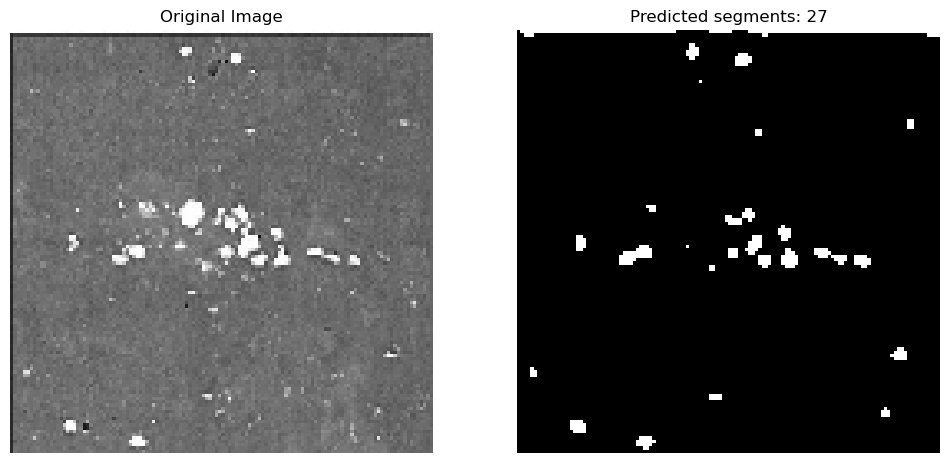

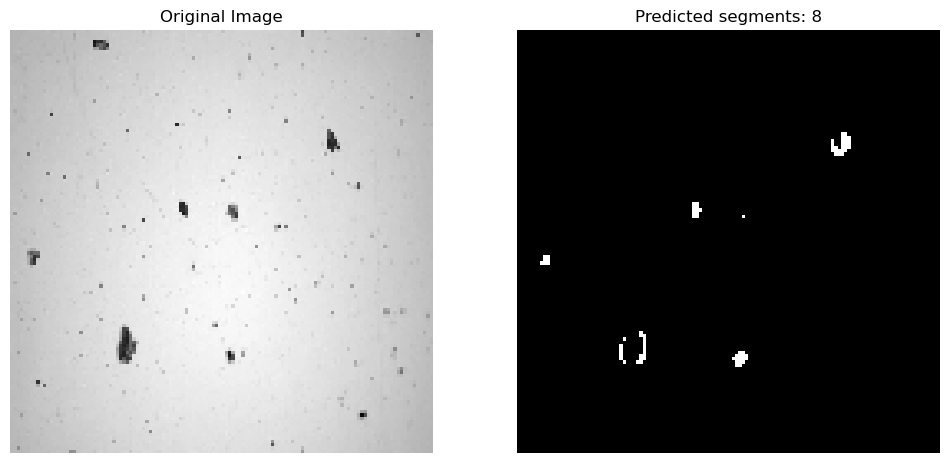

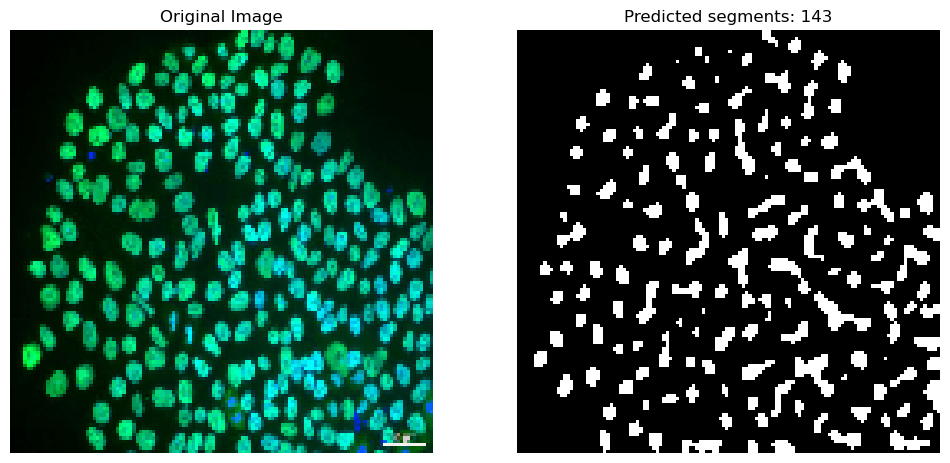

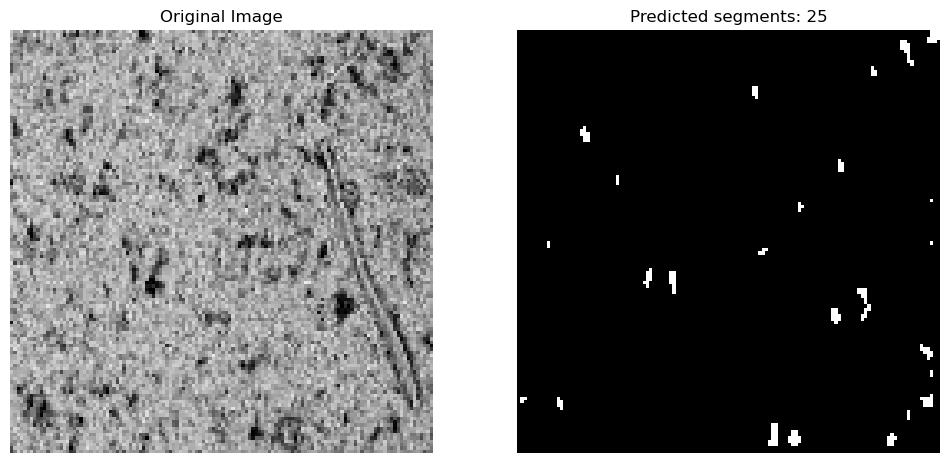

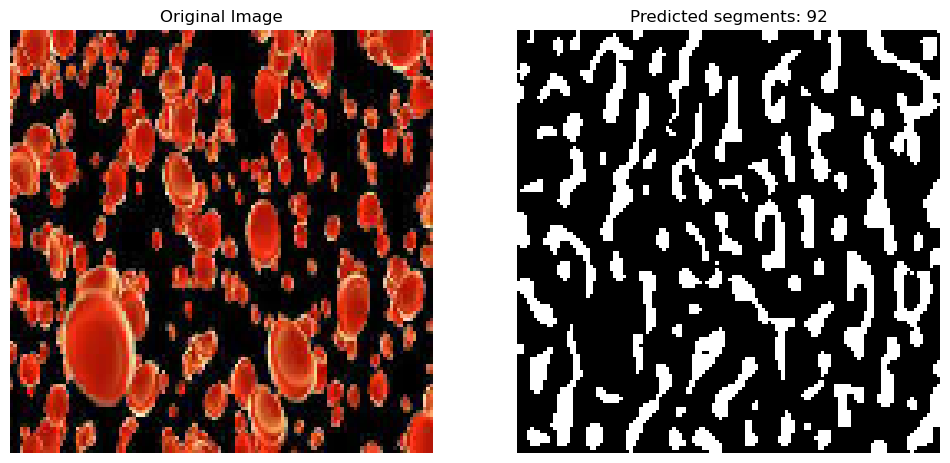

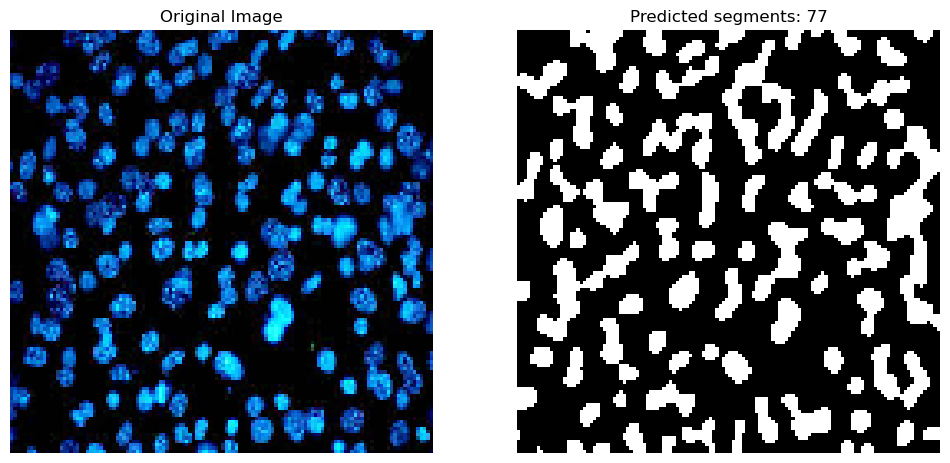

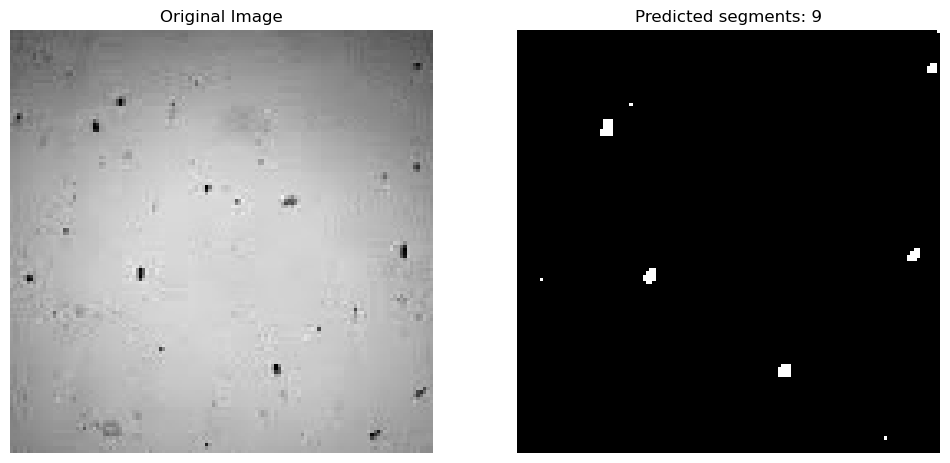

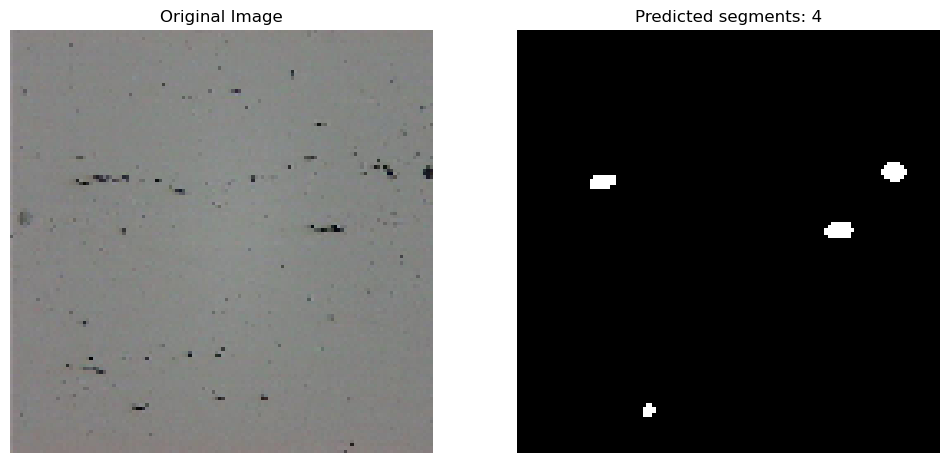

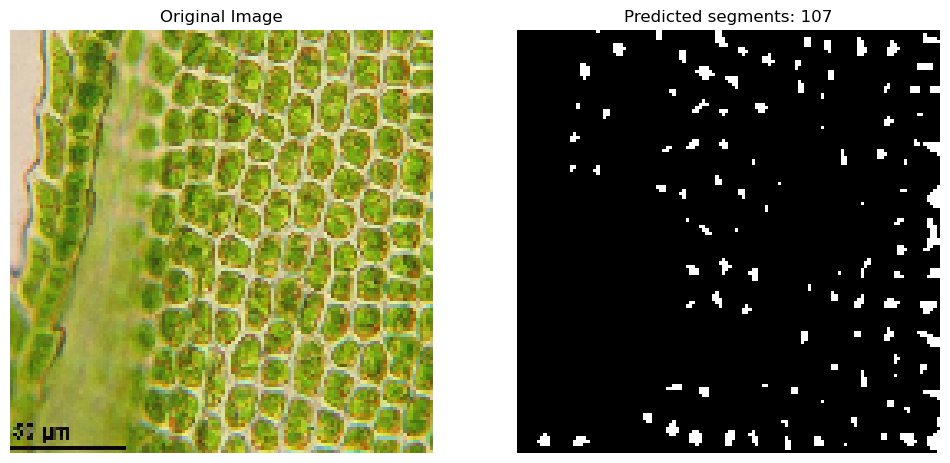

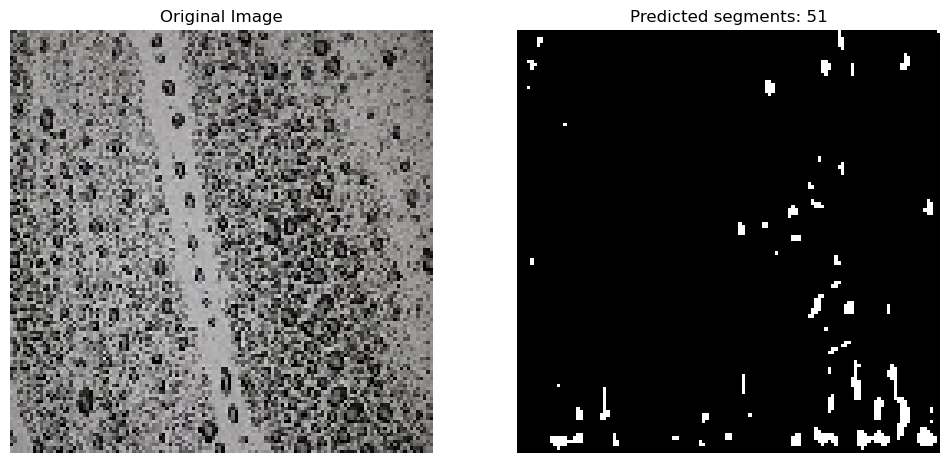

In [13]:
# prediction on real images
def load_real_images(data_dir, target_size=(128, 128)):
    X = []
    for image_file in os.listdir(data_dir):
        image_path = os.path.join(data_dir, image_file)
        image = load_img(image_path, target_size=target_size)
        image = img_to_array(image) / 255.0
        X.append(image)
    return np.array(X)


real_images_dir = "real images"
X_real = load_real_images(real_images_dir, target_size=(128, 128))
predict_and_visualize(loaded_model, X_real, num_images=20)  # Visualize predictions